# **WORKSTATION-  Automating visual inspection with ML in Agriculture**

----
#### **Required libraries import**

In [73]:
import mahotas as mh
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import os 
import joblib 

In [2]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [4]:
dt = pd.read_csv("hiroshima-lemon/train_images.csv")

In [5]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1102 non-null   object
 1   class_num  1102 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.3+ KB


In [6]:
dt['class_num'].nunique()

4

### Creating a DataFrame by Converting Images into NumPy Arrays using **Mahotas**
----

In [7]:
def get_data(folder, file):
    data = []

    ds = pd.read_csv(os.path.join(folder, file + ".csv"))

    for image_name, label in ds.values:
        image_path = os.path.join(folder, file, image_name)
        image = mh.imread(image_path)

        data.append({
            "image_name": image_name,
            "image": image, 
            "label": label 
        })

    return pd.DataFrame(data)

In [8]:
DF = get_data("hiroshima-lemon", "train_images")
DF 

,image_name,image,label
0,train_0000.jpg,"[[[101, 76, 79], [102, 77, 80], [102, 77, 80],...",0
1,train_0001.jpg,"[[[122, 102, 111], [122, 102, 111], [123, 103,...",0
2,train_0002.jpg,"[[[92, 83, 84], [92, 83, 84], [92, 83, 84], [9...",0
3,train_0003.jpg,"[[[122, 101, 110], [122, 101, 110], [122, 101,...",0
4,train_0004.jpg,"[[[138, 106, 121], [138, 106, 121], [138, 106,...",0
...,...,...,...
1097,train_1097.jpg,"[[[34, 14, 13], [34, 14, 13], [34, 14, 13], [3...",1
1098,train_1098.jpg,"[[[109, 92, 102], [109, 92, 102], [109, 92, 10...",0
1099,train_1099.jpg,"[[[40, 12, 9], [40, 12, 9], [40, 12, 9], [40, ...",1
1100,train_1100.jpg,"[[[41, 10, 5], [41, 10, 5], [41, 10, 5], [42, ...",2


In [28]:
x = DF['image'].values
y = DF['label'].values  

In [10]:
DF.columns

Index(['image_name', 'image', 'label'], dtype='object')

In [11]:
label_names = {
    0: 'excellent',
    1: 'good',
    2: 'processed products',
    3: 'disqualified'
}

### Distribution of the data in each class
---

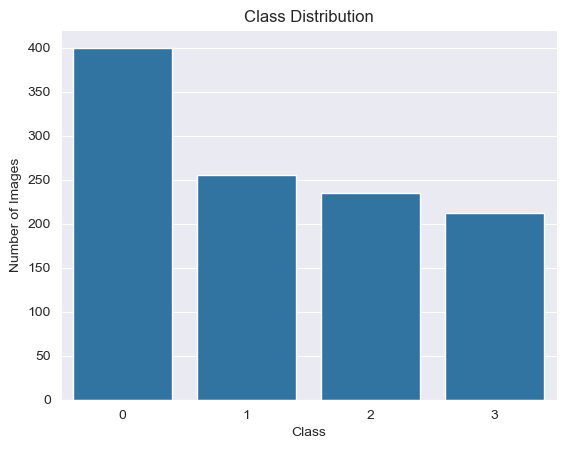

In [12]:
sns.set_style("darkgrid")
sns.countplot(x="label", data=DF)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.show()

In [29]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.20, random_state = 42
)

In [30]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("Train shape", x_train.shape) 
print("Test shape", y_test.shape) 
print(y_train.dtype)
print(y_test.dtype)

Train shape (881,)
Test shape (221,)
int64
int64


## Visualization of the training data set

In [15]:
c = pd.DataFrame(y_train, columns=['Train Class'])
c['Label Name'] = c['Train Class'].map(label_names)
c

,Train Class,Label Name
0,0,excellent
1,2,processed products
2,3,disqualified
3,2,processed products
4,0,excellent
...,...,...
876,1,good
877,2,processed products
878,1,good
879,3,disqualified


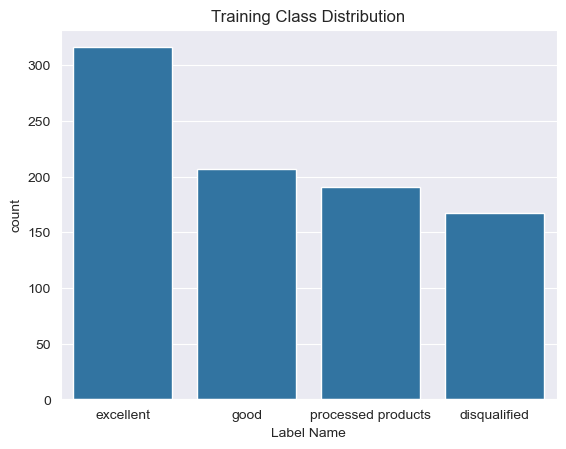

In [16]:
sns.set_style('darkgrid')
sns.countplot(
x="Label Name",
data=c,
order=['excellent', 'good', 'processed products', 'disqualified']
)


plt.title("Training Class Distribution")
plt.show()

In [17]:
s = pd.DataFrame(y_test, columns=['Train Class'])
s['Label Name'] = c['Train Class'].map(label_names)
s

,Train Class,Label Name
0,1,excellent
1,2,processed products
2,2,disqualified
3,0,processed products
4,0,excellent
...,...,...
216,3,processed products
217,1,excellent
218,0,excellent
219,3,disqualified


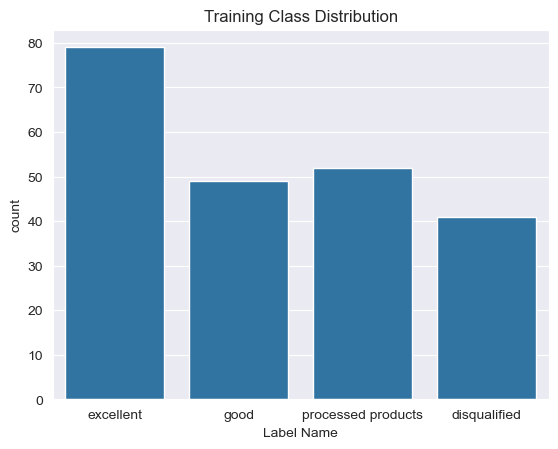

In [18]:
sns.set_style('darkgrid')
sns.countplot(
x="Label Name",
data=s,
order=['excellent', 'good', 'processed products', 'disqualified']
)
plt.title("Training Class Distribution")
plt.show()

### Feature creation  
---
Converting each Raw(RGB) image into grayscale, Haralick features, and flattens them into a fixed  length vector and returns matrix suitable for classical ML models.

In [21]:
def create_features(image):
    features = []
    for i in image:
        grey = mh.colors.rgb2grey(i, dtype = np.uint8)
        features.append(mh.features.haralick(grey).ravel())
    features = np.array(features)
    return features

In [33]:
feature_x_train = create_features(x_train)
feature_x_test = create_features(x_test)

In [34]:
print(feature_x_train.shape)
print(feature_x_test.shape)

(881, 52)
(221, 52)


### PIPELINE 

In [35]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(max_iter=1000))
])
model.fit(feature_x_train, y_train)

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [37]:
train_accy = model.score(feature_x_train, y_train)
test_accy = model.score(feature_x_test, y_test)
print(f"Train accuracy: {train_accy:.1%}")
print(f"Test accuracy: {test_accy:.1%}")

Train accuracy: 93.9%
Test accuracy: 90.5%


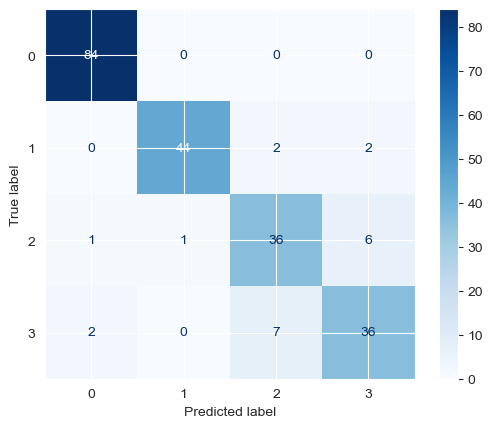

In [45]:
y_pred = model.predict(feature_x_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = "Blues")
plt.show()

In [46]:
classifiers = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA"
]

Hyperparameters = [
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel="linear", C=0.025),
    SVC(kernel="rbf", gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]


In [65]:
scores_train = []
scores_test = []

In [66]:
count = 0
for cla, hyp in zip(classifiers, Hyperparameters):
    count += 1
    print(f"{count} Training: {cla}")

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", hyp)
    ])
    model.fit(feature_x_train, y_train)

    train_accy = model.score(feature_x_train, y_train)
    test_accy = model.score(feature_x_test, y_test)

    scores_train.append(train_accy)
    scores_test.append(test_accy)

    print(f"Train Accuracy: {train_accy:.2%}")
    print(f"Test Accuracy: {test_accy:.2%}")


1 Training: Logistic Regression
Train Accuracy: 93.87%
Test Accuracy: 90.50%
2 Training: Nearest Neighbors
Train Accuracy: 93.64%
Test Accuracy: 87.33%
3 Training: Linear SVM
Train Accuracy: 77.87%
Test Accuracy: 77.38%
4 Training: RBF SVM
Train Accuracy: 99.89%
Test Accuracy: 89.14%
5 Training: Gaussian Process


C:\Users\alanf\miniconda3\envs\cv\lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alanf\miniconda3\envs\cv\lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alanf\miniconda3\envs\cv\lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alanf\miniconda3\envs\cv\lib\site-pac

Train Accuracy: 99.89%
Test Accuracy: 97.74%
6 Training: Decision Tree
Train Accuracy: 81.27%
Test Accuracy: 81.45%
7 Training: Random Forest
Train Accuracy: 79.68%
Test Accuracy: 75.57%
8 Training: Neural Net
Train Accuracy: 95.91%
Test Accuracy: 91.40%
9 Training: AdaBoost
Train Accuracy: 73.44%
Test Accuracy: 72.85%
10 Training: Naive Bayes
Train Accuracy: 68.33%
Test Accuracy: 70.14%
11 Training: QDA
Train Accuracy: 99.55%
Test Accuracy: 98.64%


C:\Users\alanf\miniconda3\envs\cv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\alanf\miniconda3\envs\cv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\alanf\miniconda3\envs\cv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\alanf\miniconda3\envs\cv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of parameter `reg_param` might help reducing the

In [69]:
res = pd.DataFrame(
    {
        "Train": scores_train,
        "Validation": scores_test
    },
    index=classifiers
)
res

,Train,Validation
Logistic Regression,0.938706,0.904977
Nearest Neighbors,0.936436,0.873303
Linear SVM,0.778661,0.773756
RBF SVM,0.998865,0.891403
Gaussian Process,0.998865,0.977376
Decision Tree,0.812713,0.814480
Random Forest,0.796822,0.755656
Neural Net,0.959137,0.914027
AdaBoost,0.734393,0.728507
Naive Bayes,0.683314,0.701357


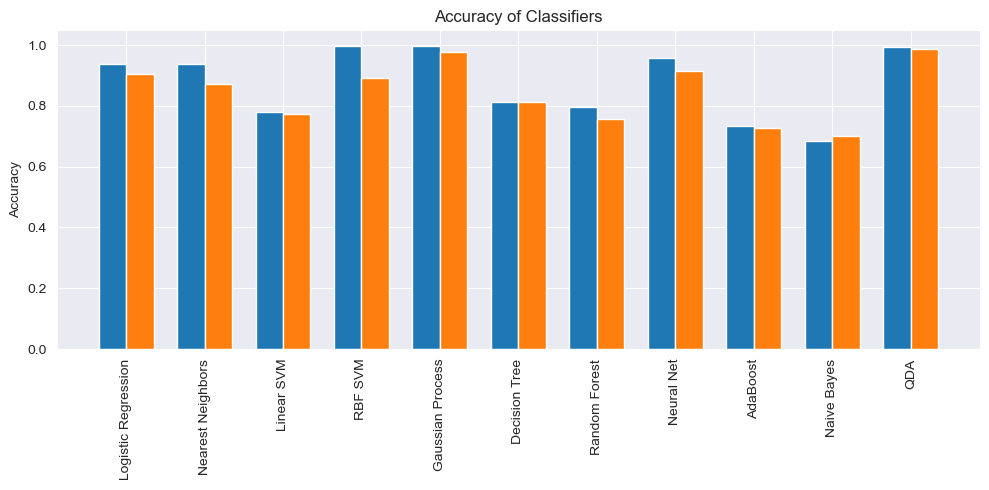

In [72]:
x = np.arange(len(classifiers))   
width = 0.35                

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x - width/2, scores_train, width, label="Train")
ax.bar(x + width/2, scores_test, width, label="Validation")

ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of Classifiers")
ax.set_xticks(x)
ax.set_xticklabels(classifiers, rotation=90)
fig.tight_layout()
plt.show()

In [68]:
print(len(classifiers))
print(len(scores_train))
print(len(scores_test))

11
11
11


### Final Model 

In [77]:
qda_model = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", QuadraticDiscriminantAnalysis())
])

qda_model.fit(feature_x_train, y_train)
train_accy =qda_model.score(feature_x_train, y_train)
test_accy = qda_model.score(feature_x_test, y_test)

print(f"Train Accuracy: {train_accy:.2%}")
print(f"Test Accuracy: {test_accy:.2%}")

Train Accuracy: 99.55%
Test Accuracy: 98.64%


C:\Users\alanf\miniconda3\envs\cv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\alanf\miniconda3\envs\cv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\alanf\miniconda3\envs\cv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\alanf\miniconda3\envs\cv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of parameter `reg_param` might help reducing the

In [76]:
joblib.dump(qda_model, "QDA_lemon.pkl")

['QDA_lemon.pkl']

In [81]:
qda_modelx = joblib.load("qda_lemon.pkl")

### Full Code
----

In [ ]:
import mahotas as mh
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import os 
import joblib 

from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix



dt = pd.read_csv("hiroshima-lemon/train_images.csv")

def get_data(folder, file):
    data = []

    ds = pd.read_csv(os.path.join(folder, file + ".csv"))

    for image_name, label in ds.values:
        image_path = os.path.join(folder, file, image_name)
        image = mh.imread(image_path)

        data.append({
            "image_name": image_name,
            "image": image, 
            "label": label 
        })

    return pd.DataFrame(data)

DF = get_data("hiroshima-lemon", "train_images")
x = DF['image'].values
y = DF['label'].values  

label_names = {
    0: 'excellent',
    1: 'good',
    2: 'processed products',
    3: 'disqualified'
}

sns.set_style("darkgrid")
sns.countplot(x="label", data=DF)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.show()

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.20, random_state = 42
)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("Train shape", x_train.shape) 
print("Test shape", y_test.shape) 
print(y_train.dtype)
print(y_test.dtype)


c = pd.DataFrame(y_train, columns=['Train Class'])
c['Label Name'] = c['Train Class'].map(label_names)
s = pd.DataFrame(y_test, columns=['Train Class'])
s['Label Name'] = c['Train Class'].map(label_names)

sns.set_style('darkgrid')
sns.countplot(
x="Label Name",
data=c,
order=['excellent', 'good', 'processed products', 'disqualified']
)
plt.title("Training Class Distribution")
plt.show()

sns.set_style('darkgrid')
sns.countplot(
x="Label Name",
data=s,
order=['excellent', 'good', 'processed products', 'disqualified']
)
plt.title("Training Class Distribution")
plt.show()

def create_features(image):
    features = []
    for i in image:
        grey = mh.colors.rgb2grey(i, dtype = np.uint8)
        features.append(mh.features.haralick(grey).ravel())
    features = np.array(features)
    return features

feature_x_train = create_features(x_train)
feature_x_test = create_features(x_test)

classifiers = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA"
]

Hyperparameters = [
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel="linear", C=0.025),
    SVC(kernel="rbf", gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]
scores_train = []
scores_test = []

count = 0
for cla, hyp in zip(classifiers, Hyperparameters):
    count += 1
    print(f"{count} Training: {cla}")

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", hyp)
    ])
    model.fit(feature_x_train, y_train)

    train_accy = model.score(feature_x_train, y_train)
    test_accy = model.score(feature_x_test, y_test)

    scores_train.append(train_accy)
    scores_test.append(test_accy)

    print(f"Train Accuracy: {train_accy:.2%}")
    print(f"Test Accuracy: {test_accy:.2%}")

res = pd.DataFrame(
    {
        "Train": scores_train,
        "Validation": scores_test
    },
    index=classifiers
)
print(res)

x = np.arange(len(classifiers))   
width = 0.35                

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x - width/2, scores_train, width, label="Train")
ax.bar(x + width/2, scores_test, width, label="Validation")

ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of Classifiers")
ax.set_xticks(x)
ax.set_xticklabels(classifiers, rotation=90)
fig.tight_layout()
plt.show()

qda_model = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", QuadraticDiscriminantAnalysis())
])

qda_model.fit(feature_x_train, y_train)
train_accy =qda_model.score(feature_x_train, y_train)
test_accy = qda_model.score(feature_x_test, y_test)

print(f"Train Accuracy: {train_accy:.2%}")
print(f"Test Accuracy: {test_accy:.2%}")

joblib.dump(qda_model, "QDA_lemon.pkl")
